In [516]:
### Required libraries ###

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from keras.models import Model, Sequential
from keras.layers import Dropout, Dense, Input, BatchNormalization, Activation, Add, LSTM, Softmax, Bidirectional, Conv1D
from keras.optimizers import Adam
from keras.utils import to_categorical, normalize
from keras import backend as K

%matplotlib inline

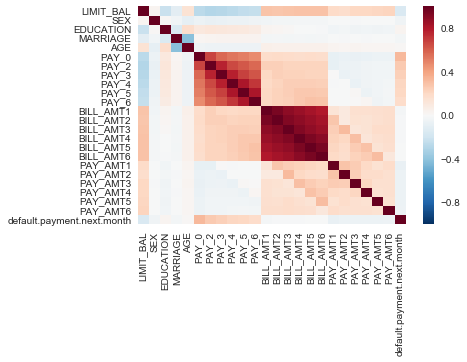

In [517]:
### Dataset ###

# reading dataset
dataset = pd.read_csv(r"D:\Data\Dinesh\Work\DLTraining\UCI Credit Card - Demographics Model\UCI_Credit_Card.csv", index_col=0)
dataset["AGE_CAT"] = pd.cut(dataset["AGE"], [0, 15, 25, 35, 45, 55, 80], labels=[15, 25, 35, 45, 55, 80])
# before using this, check how to use corelation matrix for categorical vs continous variables online
# corelation matrix
corr = dataset.corr()

# plot the heatmap
cols = list(corr.columns)
sns.heatmap(corr, 
        xticklabels=cols,
        yticklabels=cols)

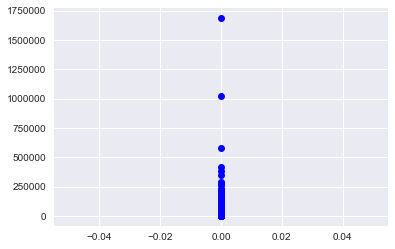

In [513]:
# plt.xticks = dataset["EDUCATION"].unique()

dataset_focus = dataset.loc[dataset["PAY_AMT1"]<=10000]
values1 = np.array(pd.DataFrame(dataset_focus[dataset_focus["SEX"] == 1]["PAY_AMT1"]))# .sample(n = 10))
values2 = np.array(pd.DataFrame(dataset_focus[dataset_focus["SEX"] == 2]["PAY_AMT2"]))# .sample(n = 10))

plt.plot(np.zeros((len(values1), 1)), values1, "bo", color = "red")
plt.plot(np.zeros((len(values2), 1)), values2, "bo", color = "blue")

# scatter_x = dataset["PAY_AMT5"]
# scatter_y = dataset["PAY_AMT4"]
# group = dataset["SEX"]
# cdict = {0: 'red', 2: 'blue'}

# fig, ax = plt.subplots()
# for g in np.unique(group):
#     ix = np.where(group == g)
#     ax.scatter(dataset["PAY_AMT5"][ix], 0, c = cdict[g], label = g, s = 100)
# ax.legend()
# plt.show()

In [514]:
### Visualizing data distribution ###

# print(dataset.columns)
sns.pairplot(dataset[['SEX', 'EDUCATION', 'MARRIAGE', 'AGE_CAT', 
                      'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3']])

KeyError: "['AGE_CAT'] not in index"

In [306]:
dataset.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month,AGE_CATEGORY
ID,,,,,,,,,,,,,,,,,,,,,
1,20000.0,2,2,1,24,2,2,-1,-1,-2,...,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1,25
2,120000.0,2,2,2,26,-1,2,0,0,0,...,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1,35
3,90000.0,2,2,2,34,0,0,0,0,0,...,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0,35
4,50000.0,2,2,1,37,0,0,0,0,0,...,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0,45
5,50000.0,1,2,1,57,-1,0,-1,0,0,...,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0,80


In [308]:
### Data Preprocessing ###

# convert to numpy array
dataset = np.array(dataset, dtype=np.float32)

m = dataset.shape[0] # no. of training examples
# preparing X, adding one_hot encoding wherever needed
X = np.concatenate((
    dataset[:, 0].reshape(m, -1), # limit
    to_categorical(dataset[:, 5]), # pay0
    to_categorical(dataset[:, 6]), # pay2
    to_categorical(dataset[:, 7]), # pay3
    to_categorical(dataset[:, 8]), # pay4
    to_categorical(dataset[:, 9]), # pay5
    dataset[:, 10:23], # bill amount and previous month payment
    to_categorical(dataset[:, 23]) # default payment flag  
), axis=1)

Y_sex = to_categorical(dataset[:, 1])
Y_education = to_categorical(dataset[:, 2])
Y_marriage = to_categorical(dataset[:, 3])
Y_age = dataset[:, 4].reshape(m, -1)
Y_age_cat = to_categorical(dataset[:, 24])
print(X.shape, Y_sex.shape, Y_education.shape, Y_marriage.shape, Y_age.shape, Y_age_cat.shape)

# print(X[0])
X = normalize(X, axis= -1, order=2)
# Y_age = normalize(Y_age, axis= -1, order=2)
# print(X[0])

(30000, 61) (30000, 3) (30000, 7) (30000, 4) (30000, 1) (30000, 81)


In [309]:
### Train and Test set preparation ###

# Splitting into test, train and dev set for each of the demographic label. All demographic labels can also be kept as single Y
X_temp, X_test, Y_education_temp, Y_education_test = train_test_split(X, Y_education, test_size=0.10, random_state=5)
X_train, X_dev, Y_education_train, Y_education_dev = train_test_split(X, Y_education, test_size=0.10, random_state=5)
X_temp, X_test, Y_sex_temp, Y_sex_test = train_test_split(X, Y_sex, test_size=0.10, random_state=5)
X_train, X_dev, Y_sex_train, Y_sex_dev = train_test_split(X, Y_sex, test_size=0.10, random_state=5)
X_temp, X_test, Y_marriage_temp, Y_marriage_test = train_test_split(X, Y_marriage, test_size=0.10, random_state=5)
X_train, X_dev, Y_marriage_train, Y_marriage_dev = train_test_split(X, Y_marriage, test_size=0.10, random_state=5)
X_temp, X_test, Y_age_temp, Y_age_test = train_test_split(X, Y_age, test_size=0.10, random_state=5)
X_train, X_dev, Y_age_train, Y_age_dev = train_test_split(X, Y_age, test_size=0.10, random_state=5)
X_temp, X_test, Y_age_cat_temp, Y_age_cat_test = train_test_split(X, Y_age_cat, test_size=0.10, random_state=5)
X_train, X_dev, Y_age_cat_train, Y_age_cat_dev = train_test_split(X, Y_age_cat, test_size=0.10, random_state=5)
'''
Note: Final datasets for 'education'(modify above two lines for any other demography) 
            - X_train, Y_education_train, X_dev, Y_education_dev, X_test, Y_education_test
'''
None

In [251]:
# X and Y for the current run, and their dimensions
X = X_train
Y = Y_education_train
m = X.shape[0] # no. of training examples
n_X = X.shape[1] # no. of features
n_Y = Y.shape[1] # no. of output classes

In [ ]:
# ### Sequential Model ###

# model = Sequential()
# model.add(Dense(units=24, activation='relu', input_dim=n_X))
# # model.add(Dropout(.8))
# model.add(Dense(units=20, activation='relu'))
# # model.add(Dropout(.8))
# model.add(Dense(units=16, activation='relu'))
# # model.add(Dropout(.8))
# model.add(Dense(units=12, activation='relu'))
# # model.add(Dropout(.8))
# model.add(Dense(units=10, activation='relu'))
# # model.add(Dropout(.8))
# model.add(Dense(units=8, activation='relu'))
# # model.add(Dropout(.8))
# model.add(Dense(units=8, activation='relu'))
# # model.add(Dropout(.8))
# model.add(Dense(units=n_Y, activation='softmax'))

# opt = Adam(lr=0.05, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.1)
# model.compile(loss='categorical_crossentropy',
#               optimizer=opt,
#               metrics=['accuracy'])
# model.summary()
# model.fit(X, Y, epochs=2, batch_size=64)

In [252]:
from keras.callbacks import Callback

class NBatchLogger(Callback):
    def __init__(self, display):
        self.seen = 0
        self.display = display

    def on_batch_end(self, batch, logs={}):
        self.seen += logs.get('size', 0)
        if self.seen % self.display == 0:
            # you can access loss, accuracy in self.params['metrics']
            print('\n{}/{} - loss ....\n'.format(self.seen, self.params['metrics'][0])) 

In [437]:
dataset = pd.read_csv(r"D:\Data\Dinesh\Work\DLTraining\UCI Credit Card - Demographics Model\UCI_Credit_Card.csv", index_col=0)
dataset_reorder = pd.read_csv(r"D:\Data\Dinesh\Work\DLTraining\UCI Credit Card - Demographics Model\UCI_Credit_Card.csv", index_col=0)

dataset_reorder["AGE_CAT"] = pd.cut(dataset_reorder["AGE"], [0, 15, 25, 35, 45, 55, 80], labels=[15, 25, 35, 45, 55, 80])

# print(dataset_reorder.columns)
dataset_reorder = dataset_reorder[[
    'PAY_6', 'BILL_AMT6', 'PAY_AMT6', 'PAY_5', 'BILL_AMT5', 'PAY_AMT5', 'PAY_4', 'BILL_AMT4', 'PAY_AMT4', 
    'PAY_3', 'BILL_AMT3', 'PAY_AMT3', 'PAY_2', 'BILL_AMT2', 'PAY_AMT2', 'PAY_0', 'BILL_AMT1', 'PAY_AMT1',
    "EDUCATION", "MARRIAGE", "SEX", "AGE_CAT", "default.payment.next.month"
]]

neg_num_categorical_columns = ["PAY_0", "PAY_2", "PAY_3", "PAY_4", "PAY_5", "PAY_6"]
for column in negative_categorical_columns:
    min_value = abs(dataset_reorder[column].min())
    dataset_reorder[column] += abs(min_value)
    
# print(dataset_reorder["PAY_0"].unique())
# to_categorical(dataset_reorder["PAY_0"].unique())
dataset = np.array(dataset)
dataset_reorder = np.array(dataset_reorder)

In [442]:
n_rows = dataset_reorder.shape[0]

X_reorder = np.concatenate(
    (
        to_categorical(dataset_reorder[: , 0]),
        dataset_reorder[:, [1, 2]],
        to_categorical(dataset_reorder[: , 3]),
        dataset_reorder[:, [4, 5]],
        to_categorical(dataset_reorder[: , 6]),
        dataset_reorder[:, [7, 8]],
        to_categorical(dataset_reorder[: , 9]),
        dataset_reorder[:, [10, 11]],
        to_categorical(dataset_reorder[: , 12]),
        dataset_reorder[:, [13, 14]],
        to_categorical(dataset_reorder[: , 15]),
        dataset_reorder[:, [16, 17]]
    )
    , axis = 1
)
Y_reorder_education = to_categorical(dataset_reorder[:, 18])
print(X_reorder.shape, Y_reorder_education.shape, to_categorical(dataset_reorder[: , 15]).shape)

(30000, 78) (30000, 7) (30000, 11)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_62 (InputLayer)        (None, 78, 1)             0         
_________________________________________________________________
conv1d_28 (Conv1D)           (None, 38, 1)             4         
_________________________________________________________________
bidirectional_41 (Bidirectio (None, 32)                2304      
_________________________________________________________________
dense_60 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_61 (Dense)             (None, 7)                 119       
Total params: 2,955
Trainable params: 2,955
Non-trainable params: 0
_________________________________________________________________
Epoch 1/2
30000/30000 [==============================] - 15s 491us/step - loss: 0.1054 - acc: 0.4541

In [408]:
X_payment_pred = normalize(np.array(dataset[:, 17:22], dtype="float32").reshape(30000, 5, 1))
Y_payment_pred = normalize(np.array(dataset[:, 22], dtype="float32").reshape(30000, 1))

X_default_pred = normalize(np.array(dataset[:, 17:23], dtype="float32").reshape(30000 , 6, 1))
Y_default_pred = to_categorical(np.array(dataset[:, 23], dtype="float32")).reshape(30000, 2)

X_seq = X_payment_pred
Y_seq = Y_payment_pred
m_seq = X_seq.shape[0]
n_X_seq = X_seq.shape[1]
n_X_seq_el = X_seq.shape[2]
n_Y_seq = Y_seq.shape[1]

In [410]:
X_input = Input(shape = (n_X_seq, n_X_seq_el,))
A = Bidirectional(LSTM(32))(X_input)
# print(A.shape)
# Y_layer = Dense(n_Y_seq, activation = "softmax")(A)
Y_layer = Dense(n_Y_seq, activation = "linear")(A)

model = Model(inputs = (X_input), outputs = (Y_layer))
opt = Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.1)
# model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
model.compile(loss='mean_squared_error', optimizer=opt, metrics=['accuracy'])

# print(X[:, 17:23].reshape(m, 6, 1).shape)
# print(X[:, 17:23].reshape(m, 1, 6)[0:3])
model.fit(X_seq, Y_seq, epochs = 2, batch_size=64)

Epoch 1/2
30000/30000 [==============================] - 6s 186us/step - loss: 0.1257 - acc: 0.8307

In [206]:
### Dymanic model ###

# clearing session so far, if something is run by mistake
K.clear_session()

# input layer
X_input = Input(shape = (n_X,))
A = X_input

# hidden layer
# list having no. of activations in each layer
add_this_a = None
fix_add_this_a = False
layers_dims = [1024, 1024]
for i, dim in enumerate(layers_dims):
    layer_no = i + 1
    if layer_no%3 == 0 and layer_no/3 > 1:
        skip_add = True
    else:
        skip_add = False
    if (layer_no + 2)%3 == 0:
        add_this_A = True
    else:
        add_this_A = False
    A = Dense(dim, activation = "linear")(A) # to change activation check here, https://keras.io/activations/
    if skip_add == True:
        print("skip add at", layer_no)
        Add()([A, to_add_A])
    A = Activation("relu")(A)
    if add_this_A == True:
        to_add_A = A
        print("fetching to add A at", layer_no)
    A = BatchNormalization()(A)
#     A = Dropout(0.7)(A) # add dropout, if needed
# print(A) 
Y_layer = Dense(n_Y, activation="softmax")(A)
# Y_layer = Dense(1, activation="linear")(A)
model = Model(inputs = [X_input], outputs = [Y_layer])

# adam optimizer - try different learning rates here
opt = Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.1)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
# model.compile(loss='mean_squared_error', optimizer=opt, metrics=['accuracy'])
# prints model graph
model.summary()

fetching to add A at 1
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 61)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               15872     
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dense_2 (Dense)              (None, 7)                 1799      
Total params: 18,695
Trainable params: 18,183
Non-trainable params: 512
_________________________________________________________________


In [208]:
# training model
model.fit(X, Y, epochs=10, batch_size=64)
# out_batch = NBatchLogger(display= 1000)
# model.fit(X, Y, epochs=50, batch_size=64,callbacks=[out_batch])

Epoch 1/10
27000/27000 [==============================] - 1s 21us/step - loss: 1.0679 - acc: 0.5129

In [57]:
model.evaluate(X_dev, Y_age_dev)
model.evaluate(X_test, Y_age_test)

3000/3000 [==============================] - 0s 11us/step


[3.552713678800501e-11, 1.0]

In [61]:
predictions = model.predict(X_test)
print(predictions[0:3], Y_age_test[0:3])

[[0.99999404]
 [0.99999404]
 [0.99999404]] [[1.]
 [1.]
 [1.]]
